Create a function to analyze the effect of gene knockouts on single-cell gene expression data using pre-trained foundation models. Compare embeddings before and after knockout and classify the samples.

The data we will work with through out different examples is a subset of the human PBMC, comprising 54,760 training cells and 13,690 test cells, with 16,906 genes across 11 distinct cell types. We have provided an automatic download link below (it checks if the file already exsists and dowloads it if not).



## Setup

In [1]:
try:
    import helical
except:
    !pip install git+https://github.com/helicalAI/helical.git |tail -n 1
    !pip install numpy==1.23.5
    import helical

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed


In [2]:
!pip install anndata torch transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import os
import requests
import anndata as ad
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from helical.models.scgpt.model import scGPT, scGPTConfig

10k_pbmcs_proc.h5ad already exist. Skipping downloads.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Load data and model

In [ ]:
url = "https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"{filename} already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

In [5]:
# model is loaded from Helical
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)

Downloading: 100%|██████████| 1.32M/1.32M [00:00<00:00, 1.74MB/s]
Downloading:  97%|█████████▋| 201M/208M [00:07<00:00, 97.0MB/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b7700>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b6d40>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b63e0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b6c80>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b5660>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b6020>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b343bf22c0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b7460>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b4e80>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x78b34a7b6bc0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH)

In [7]:
# load data
ann_data = ad.read_h5ad("10k_pbmcs_proc.h5ad")
ann_data

AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

In [ ]:
# if from HF (placeholders)
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# data = ann_data.X.toarray()
# # check data format (padding? truncation?)
# inputs = tokenizer(data, return_tensors='pt', padding=True, truncation=True)
# # get embeddings
# with torch.no_grad():
#     outputs = model(**inputs)
# # assuming the model outputs embeddings in the last hidden state
# embeddings = outputs.last_hidden_state.mean(dim=1).numpy()


## Apply knockout perturbation & generate embeddings

In [59]:
# let's knockout 50% of genes (random, first k genes)
k=0.5
kgenes = ann_data.var["gene_symbols"][0:int(len(ann_data.var["gene_symbols"])*k)].to_list()
print(len(kgenes)) # 6000
print(kgenes[0:10])

6000
['SAMD11', 'PLEKHN1', 'HES4', 'ISG15', 'AGRN', 'C1orf159', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4']


In [60]:
# To knockout a gene in the context of genomics => its gene expression is 0
def perturb_data(ann_data, kgenes):
    perturbed_ann_data = ann_data.copy()
    gene_indices = [ann_data.var_names.get_loc(gene) for gene in kgenes]
    perturbed_ann_data.X[:, gene_indices] = 0
    return perturbed_ann_data

# Create perturbed data
p_ann_data = perturb_data(ann_data, kgenes)
p_ann_data

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type', 'total_counts'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

In [61]:
# generate embeddings
dataset = scgpt.process_data(ann_data, gene_names="gene_symbols")
p_dataset = scgpt.process_data(p_ann_data, gene_names="gene_symbols")

embeddings = scgpt.get_embeddings(dataset)
p_embeddings = scgpt.get_embeddings(p_dataset)
print(embeddings.shape)
print(p_embeddings.shape)

Embedding cells: 100%|██████████| 240/240 [01:41<00:00,  2.35it/s]

(11990, 512)
(11990, 512)


## Visualization of original and perturbed embeddings
*Plot and compare the embeddings.*

*Measure similarity and describe the impact of gene knockouts.*

In [63]:
# Generate labels: 0 for original, 1 for perturbed
original_labels = np.zeros(embeddings.shape[0])
perturbed_labels = np.ones(p_embeddings.shape[0])

# Combine embeddings and labels
combined_embeddings = np.vstack((embeddings, p_embeddings))
combined_labels = np.concatenate((original_labels, perturbed_labels))
print(combined_embeddings.shape)
print(combined_labels.shape)

(23980, 512)
(23980,)


In [64]:
# visualize embeddings through UMAP 2-dim-reduced representation
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_rep = umap_reducer.fit_transform(combined_embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


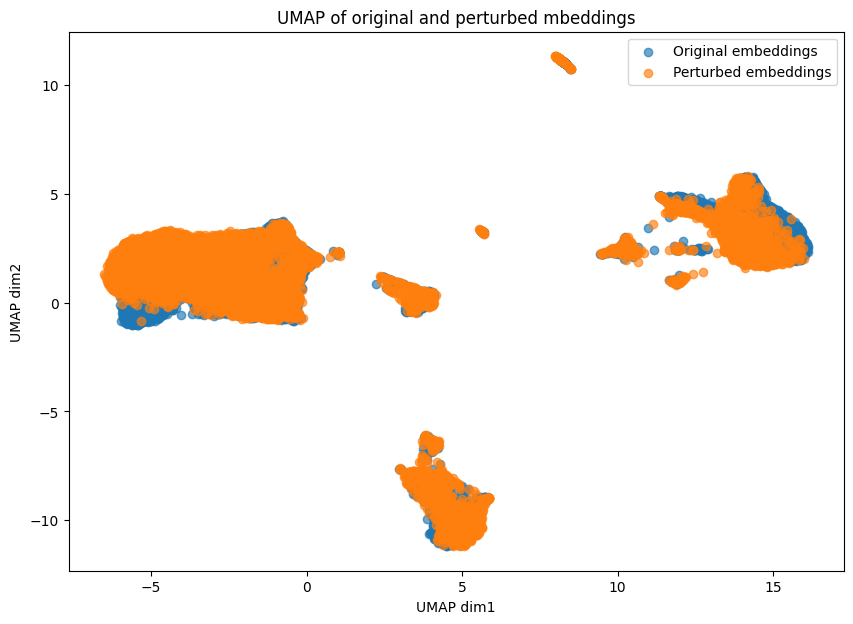

In [86]:
# plot UMAP
plt.figure(figsize=(10, 7))
plt.scatter(umap_rep[combined_labels == 0, 0], umap_rep[combined_labels == 0, 1], label='Original embeddings', alpha=0.65)
plt.scatter(umap_rep[combined_labels == 1, 0], umap_rep[combined_labels == 1, 1], label='Perturbed embeddings', alpha=0.65)
plt.xlabel('UMAP dim1')
plt.ylabel('UMAP dim2')
plt.legend()
plt.title('UMAP of original and perturbed mbeddings')
plt.show()


Visually, it seems that the knockouts have little impact in the embeddings. Let's see with the euclidean and cosine distances:

In [91]:
from scipy.spatial.distance import euclidean, cosine

# Calculate pairwise distances
euclidean_distances = [euclidean(embeddings[i], p_embeddings[i]) for i in range(len(embeddings))]
cosine_distances = [cosine(embeddings[i], p_embeddings[i]) for i in range(len(embeddings))]

# Calculate average distance
average_distance = np.mean(euclidean_distances)
print(f'Average euclidean distance: {average_distance}')
average_distance = np.mean(cosine_distances)
print(f'Average cosine distance: {average_distance}')

Average euclidean distance: 0.21764454159068505
Average cosine distance: 0.024891844058348458


Lower values of distance suggest closer (i.e., more similar) embeddings between the original and perturbed ones. However, the interpretability of distance among embeddings in absolute terms is not straightforward. I can say though that I tried different k ratio of genes knocked out, and the distance increased with the number of knockouts.

The cosine distance is very small, indicating that the original and knockout embeddings are highly aligned in terms of their orientation, which also aligns with what is seen in the UMAP representation.

## Classification task

*Build a simple neural network (or other classifier) to classify the embeddings into perturbed and unperturbed samples (based on the ones you just created)*

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [123]:
# Convert to tensor
X = torch.tensor(combined_embeddings)
y = torch.tensor(combined_labels, dtype=torch.long)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [124]:
# define model
class MLP3l(torch.nn.Module):
    def __init__(self, in_f, h1_f, h2_f, p_dropout, out_f=2):
        super(MLP3l, self).__init__()
        torch.manual_seed(42)
        self.lin1 = nn.Linear(in_f, h1_f)
        self.lin2 = nn.Linear(h1_f, h2_f)
        self.lin3 = nn.Linear(h2_f, out_f)
        self.bn1 = nn.BatchNorm1d(h1_f)
        self.bn2 = nn.BatchNorm1d(h2_f)
        self.p_dropout = p_dropout

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.bn1(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)
        x = F.relu(self.lin2(x))
        x = self.bn2(x)
        x = F.dropout(x, p=self.p_dropout, training=self.training)
        out = self.lin3(x)
        return out


In [125]:
# Initialize the model & config
model = MLP3l(in_f=X.shape[1], h1_f=64, h2_f=128, p_dropout=0.2, out_f=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50

In [130]:
n_epochs = 10
for epoch in range(n_epochs):
    # training
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch_y.view_as(pred)).sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}, Accuracy: {accuracy}%')

Epoch 1, Loss: 0.0003619226044975221, Val Loss: 0.0001927463230332752, Accuracy: 99.77064220183486%
Epoch 2, Loss: 0.005524088628590107, Val Loss: 0.00041012190932641874, Accuracy: 99.52043369474562%
Epoch 3, Loss: 0.0030903650913387537, Val Loss: 0.00021226392578270215, Accuracy: 99.81234361968306%
Epoch 4, Loss: 0.00450325571000576, Val Loss: 0.00019214774851945862, Accuracy: 99.85404503753128%
Epoch 5, Loss: 0.0010147213470190763, Val Loss: 0.0002480742476320174, Accuracy: 99.77064220183486%
Epoch 6, Loss: 0.06431294977664948, Val Loss: 0.0001486507333840512, Accuracy: 99.89574645537948%
Epoch 7, Loss: 0.05072230100631714, Val Loss: 0.00016189743602157617, Accuracy: 99.89574645537948%
Epoch 8, Loss: 0.00652399891987443, Val Loss: 0.0005892204676149248, Accuracy: 99.4161801501251%
Epoch 9, Loss: 6.321325054159388e-05, Val Loss: 0.00036703550826370596, Accuracy: 99.83319432860718%
Epoch 10, Loss: 0.0007552737952210009, Val Loss: 0.0002406477112562576, Accuracy: 99.77064220183486%
